In [1]:
import pandas as pd
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark
!pip install --upgrade pandas seaborn

Se importa la libreria spark y se genera la sesion para facilitar la consultas mediante saql y realizar los cruces entres las tres bases de informacion y seleccionar solamente el numero adecuado de columnas

In [4]:
spark = SparkSession.builder \
    .appName("Colab PySpark") \
    .getOrCreate()

In [5]:
listing = pd.read_csv('Listing_clean.csv')
booked = pd.read_csv('booked_list.csv')
review = pd.read_csv('review_list.csv')

In [6]:
listing  = spark.createDataFrame(listing)
booked = spark.createDataFrame(booked)
review = spark.createDataFrame(review)

In [7]:
spark = SparkSession.builder \
    .appName("Colab PySpark") \
    .getOrCreate()

In [8]:
listing.createOrReplaceTempView('listing')
booked.createOrReplaceTempView('booked')
review.createOrReplaceTempView('review')

In [9]:
df = spark.sql("""
              select a.id
                    ,a.source
                    ,a.neighbourhood_cleansed
                    ,a.neighbourhood_group_cleansed
                    ,a.property_type,room_type
                    ,a.accommodates,bathrooms
                    ,a.bathrooms_text
                    ,a.bedrooms
                    ,a.beds
                    ,a.amenities
                    ,case when a.amenities ilike '%wifi%' then 'wifi' else 'no wifi' end as wifi
                    ,Case when a.amenities ilike '%Kitchen%' then 'Kitchen' else 'no Kitchen' end as Kitchen
                    ,Case when a.amenities ilike '%parking%' then 'parking' else 'no parking' end as parking
                    ,a.price
                    ,a.minimum_nights
                    ,a.number_of_reviews
                    ,a.review_scores_rating
                    ,a.review_scores_location
                    ,a.license
                    ,a.instant_bookable
                    ,b.booked
                    ,c.review_count
                    from listing a
                    left join (select listing_id,sum(booked) as booked from booked group by listing_id ) b on a.id = b.listing_id
                    left join review c on a.id = c.listing_id
""")

In [10]:
pandas_df = df.toPandas()

In [11]:
df.createOrReplaceTempView('TablaFinal')

In [12]:
pandas_df.head()

,id,source,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,...,parking,price,minimum_nights,number_of_reviews,review_scores_rating,review_scores_location,license,instant_bookable,booked,review_count
0,49048,city scrape,Bedford-Stuyvesant,Brooklyn,Private room in home,Private room,3,2.0,2 baths,1.0,...,parking,95.0,30,27,4.42,4.38,NaN,f,150.0,4.0
1,385824,city scrape,Spuyten Duyvil,Bronx,Entire guest suite,Entire home/apt,2,1.0,1 bath,2.0,...,parking,214.0,30,146,4.74,4.87,NaN,f,61.0,37.0
2,818518,city scrape,Harlem,Manhattan,Private room in condo,Private room,2,1.0,1 shared bath,1.0,...,parking,99.0,30,85,4.60,4.68,NaN,f,276.0,17.0
3,867020,city scrape,Greenpoint,Brooklyn,Private room in rental unit,Private room,1,1.0,1 shared bath,1.0,...,no parking,60.0,31,12,4.83,4.92,NaN,f,46.0,NaN
4,1617443,city scrape,Harlem,Manhattan,Entire rental unit,Entire home/apt,2,1.0,1 bath,1.0,...,parking,65.0,30,37,4.70,4.63,NaN,f,365.0,NaN


### *Se genera un analisis del numero de reservas por sector de la ciudad donde visusalisamos que las dos zonas mas reservadas son Brooklyn y Manhattan*

In [13]:
colores_zona = {'Bronx': 'blue', 'Brooklyn': 'green', 'Manhattan': 'red','Queens':'orange','Staten Island':'black'}

In [14]:
pandas_df.groupby(['neighbourhood_group_cleansed']).agg(
                            review_count=('booked', 'count')
                            ).reset_index()

,neighbourhood_group_cleansed,review_count
0,Bronx,744
1,Brooklyn,7318
2,Manhattan,9154
3,Queens,3452
4,Staten Island,277


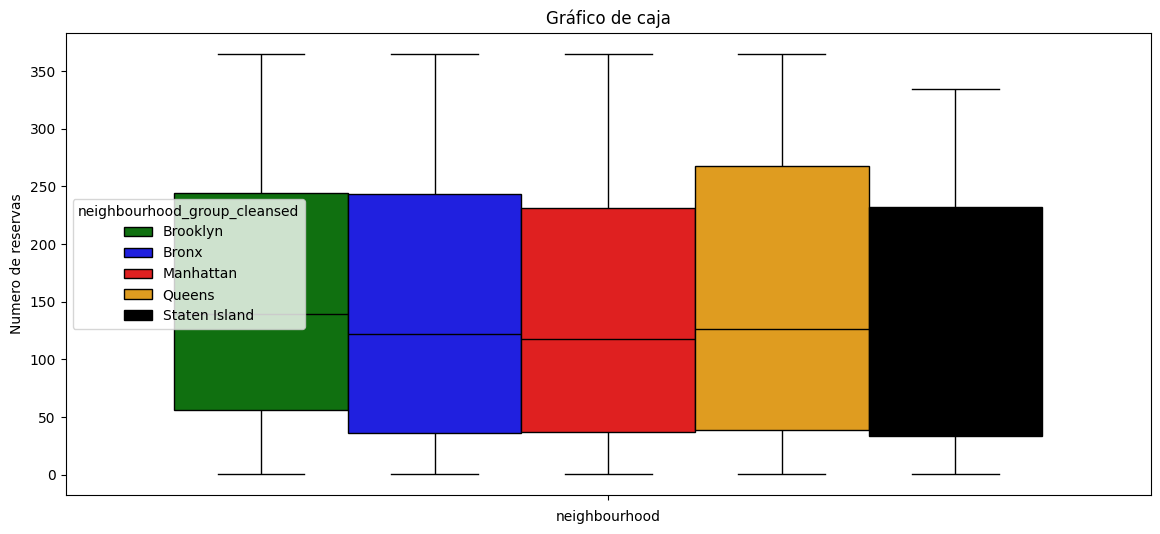

In [15]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=pandas_df, hue='neighbourhood_group_cleansed', y='booked',palette=colores_zona)
plt.xlabel('neighbourhood')
plt.ylabel('Numero de reservas')
plt.title('Gráfico de caja')
plt.show()

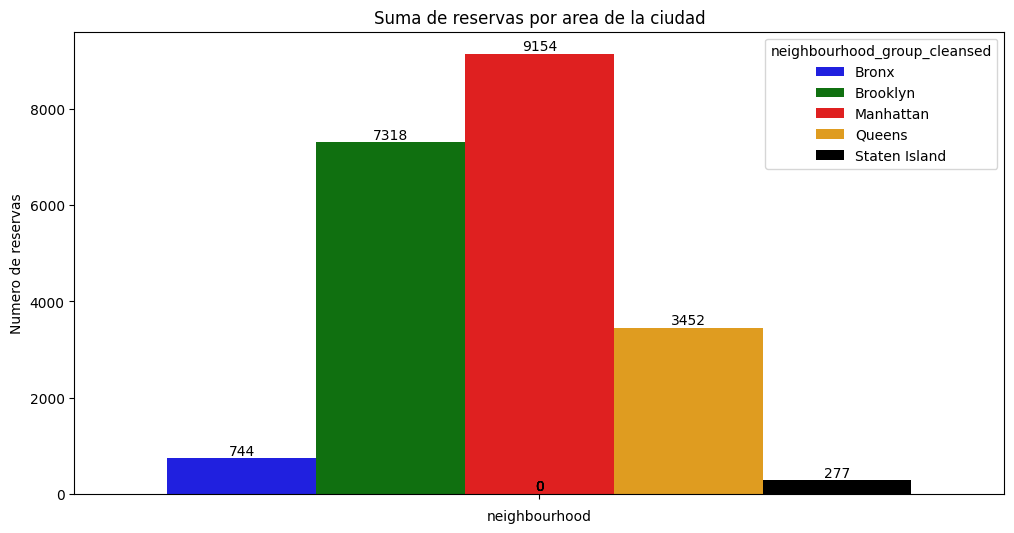

In [16]:

plt.figure(figsize=(12, 6))
mean_values = pandas_df.groupby('neighbourhood_group_cleansed')['booked'].count().reset_index()
ax = sns.barplot(data=mean_values, hue='neighbourhood_group_cleansed', y='booked',palette=colores_zona)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')
plt.title('Suma de reservas por area de la ciudad')
plt.xlabel('neighbourhood')
plt.ylabel('Numero de reservas')
plt.show()


In [17]:
pandas_df.groupby(['neighbourhood_group_cleansed']).agg(
                            Mean_price=('price', 'mean')
                            ).reset_index()

,neighbourhood_group_cleansed,Mean_price
0,Bronx,116.817654
1,Brooklyn,163.664879
2,Manhattan,246.921587
3,Queens,129.903361
4,Staten Island,120.469256


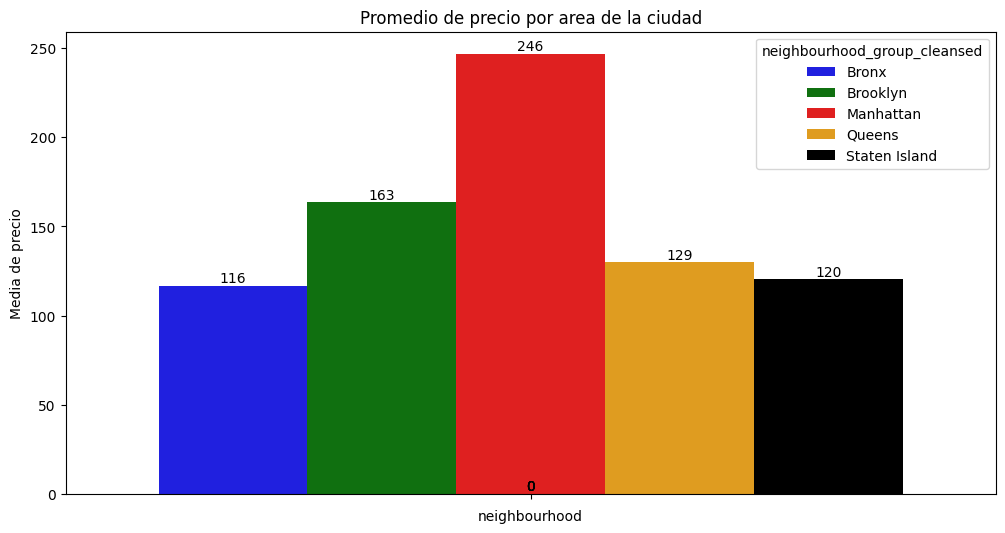

In [18]:
plt.figure(figsize=(12, 6))
mean_values = pandas_df.groupby('neighbourhood_group_cleansed')['price'].mean().reset_index()
ax = sns.barplot(data=mean_values, hue='neighbourhood_group_cleansed', y='price',palette=colores_zona)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')
plt.title('Promedio de precio por area de la ciudad')
plt.xlabel('neighbourhood')
plt.ylabel('Media de precio')
plt.show()

Se genera un desglosamiento por barrios para conocer la distribucion de los alquileres por las dos zonas antes mencionadas

In [19]:
alquileres_barrios_man=pandas_df[pandas_df['neighbourhood_group_cleansed']=='Manhattan'].groupby(['neighbourhood_cleansed']).agg(
                            count=('booked', 'count')
                            ).reset_index().sort_values(by='count', ascending=False)
alquileres_barrios_man

,neighbourhood_cleansed,count
17,Midtown,1304
11,Hell's Kitchen,975
10,Harlem,956
28,Upper East Side,921
29,Upper West Side,743
1,Chelsea,460
5,East Village,435
4,East Harlem,392
6,Financial District,332
15,Lower East Side,305


In [20]:
alquileres_barrios_man['participacion'] = (alquileres_barrios_man['count']/alquileres_barrios_man['count'].sum()) * 100
alquileres_barrios_man

,neighbourhood_cleansed,count,participacion
17,Midtown,1304,14.245139
11,Hell's Kitchen,975,10.651081
10,Harlem,956,10.443522
28,Upper East Side,921,10.061175
29,Upper West Side,743,8.116670
1,Chelsea,460,5.025126
5,East Village,435,4.752021
4,East Harlem,392,4.282281
6,Financial District,332,3.626830
15,Lower East Side,305,3.331877


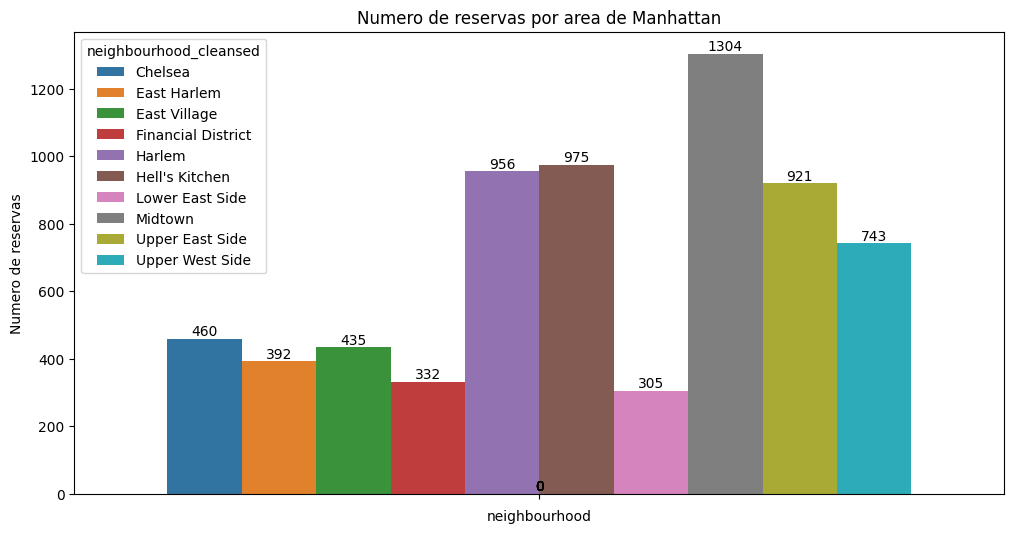

In [21]:
plt.figure(figsize=(12, 6))
mean_values = pandas_df[pandas_df['neighbourhood_group_cleansed']=='Manhattan'].groupby('neighbourhood_cleansed')['booked'].count().reset_index()
mean_values = mean_values[mean_values['booked']>300]
ax = sns.barplot(data=mean_values, hue='neighbourhood_cleansed', y='booked')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')
plt.title('Numero de reservas por area de Manhattan')
plt.xlabel('neighbourhood')
plt.ylabel('Numero de reservas')
plt.show()

In [22]:
alquileres_barrios_broo=pandas_df[pandas_df['neighbourhood_group_cleansed']=='Brooklyn'].groupby(['neighbourhood_cleansed']).agg(
                            count=('booked', 'count')
                            ).reset_index().sort_values(by='count', ascending=False)
alquileres_barrios_broo

,neighbourhood_cleansed,count
2,Bedford-Stuyvesant,1579
46,Williamsburg,850
10,Bushwick,706
17,Crown Heights,624
22,East Flatbush,366
31,Greenpoint,273
24,Flatbush,257
23,East New York,242
39,Prospect-Lefferts Gardens,192
11,Canarsie,165


In [23]:
alquileres_barrios_broo['participacion'] = (alquileres_barrios_broo['count']/alquileres_barrios_broo['count'].sum()) * 100
alquileres_barrios_broo

,neighbourhood_cleansed,count,participacion
2,Bedford-Stuyvesant,1579,21.576934
46,Williamsburg,850,11.615195
10,Bushwick,706,9.647445
17,Crown Heights,624,8.526920
22,East Flatbush,366,5.001366
31,Greenpoint,273,3.730527
24,Flatbush,257,3.511888
23,East New York,242,3.306914
39,Prospect-Lefferts Gardens,192,2.623668
11,Canarsie,165,2.254714


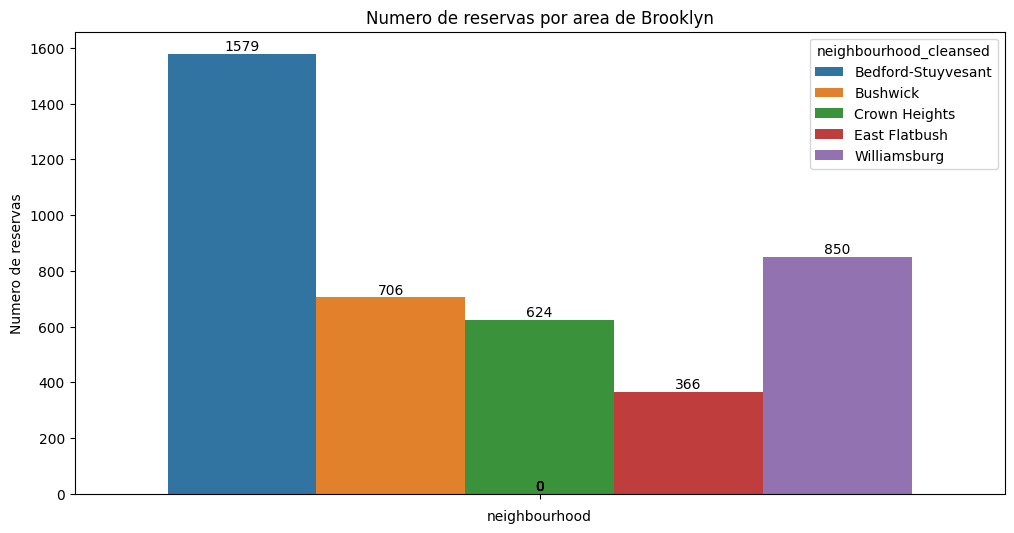

In [24]:
plt.figure(figsize=(12, 6))
mean_values = pandas_df[pandas_df['neighbourhood_group_cleansed']=='Brooklyn'].groupby('neighbourhood_cleansed')['booked'].count().reset_index()
mean_values = mean_values[mean_values['booked']>300]
ax = sns.barplot(data=mean_values, hue='neighbourhood_cleansed', y='booked')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')
plt.title('Numero de reservas por area de Brooklyn')
plt.xlabel('neighbourhood')
plt.ylabel('Numero de reservas')
plt.show()

Se genera la segmentacion de el tipo de baños por cantidad de reservas

In [25]:
pandas_df.groupby(['bathrooms_text']).agg(
                            Number_booked=('booked', 'count')
                            ).reset_index().sort_values(by='Number_booked', ascending=False)

,bathrooms_text,Number_booked
2,1 bath,10870
4,1 shared bath,3779
3,1 private bath,1916
9,2 baths,1760
10,2 shared baths,628
5,1.5 baths,572
1,0 shared baths,344
6,1.5 shared baths,313
11,2.5 baths,210
13,3 baths,172


Se segmenta la informacion por el tipo de habitacion y el numero de reservas

In [26]:
pandas_df.groupby(['room_type']).agg(
                            Number_booked=('booked', 'count')
                            ).reset_index().sort_values(by='Number_booked', ascending=False)

,room_type,Number_booked
0,Entire home/apt,11613
2,Private room,8792
3,Shared room,283
1,Hotel room,257


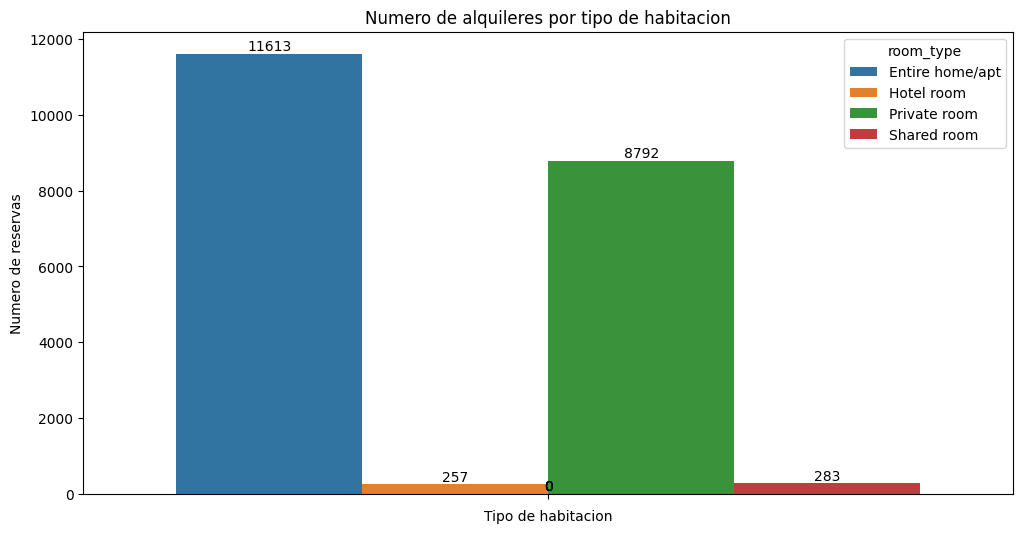

In [27]:
plt.figure(figsize=(12, 6))
mean_values = pandas_df.groupby('room_type')['booked'].count().reset_index()
ax = sns.barplot(data=mean_values, hue='room_type', y='booked')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')
plt.title('Numero de alquileres por tipo de habitacion')
plt.xlabel('Tipo de habitacion')
plt.ylabel('Numero de reservas')
plt.show()

Se calcula el promedio de precio por tipo de habitacion

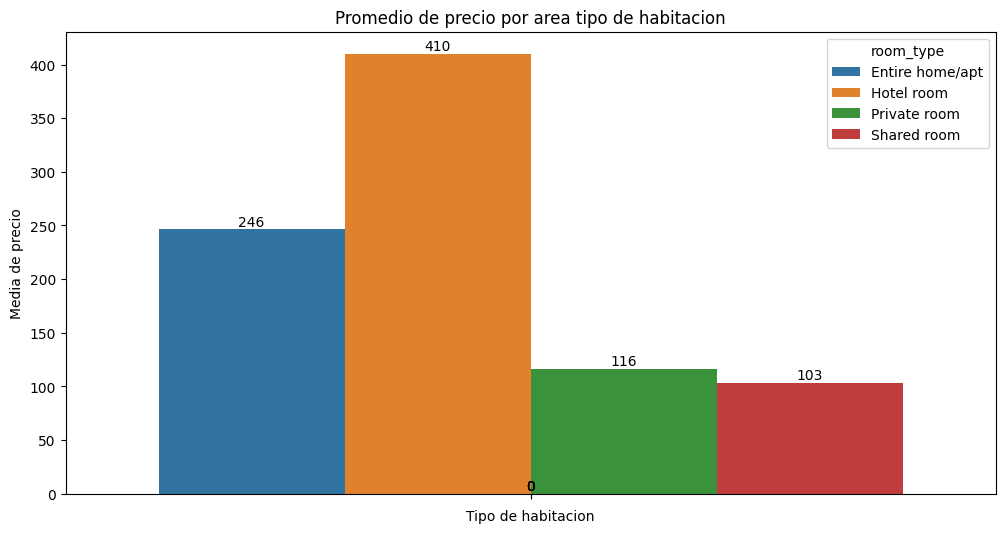

In [28]:
plt.figure(figsize=(12, 6))
mean_values = pandas_df.groupby('room_type')['price'].mean().reset_index()
ax = sns.barplot(data=mean_values, hue='room_type', y='price')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')
plt.title('Promedio de precio por area tipo de habitacion')
plt.xlabel('Tipo de habitacion')
plt.ylabel('Media de precio')
plt.show()

Se generan los correspondientes graficos de dispercion de las variables cuantitativas

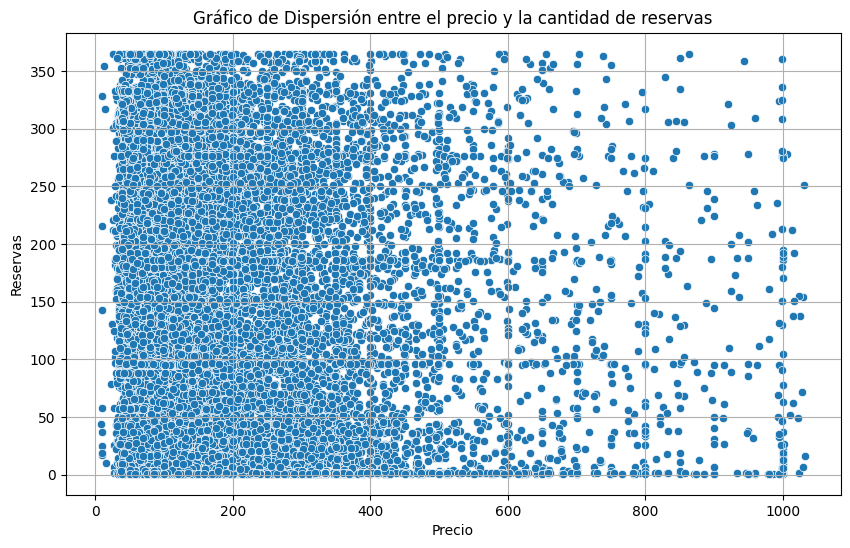

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pandas_df, x='price', y='booked')
plt.title('Gráfico de Dispersión entre el precio y la cantidad de reservas')
plt.xlabel('Precio')
plt.ylabel('Reservas')
plt.grid()

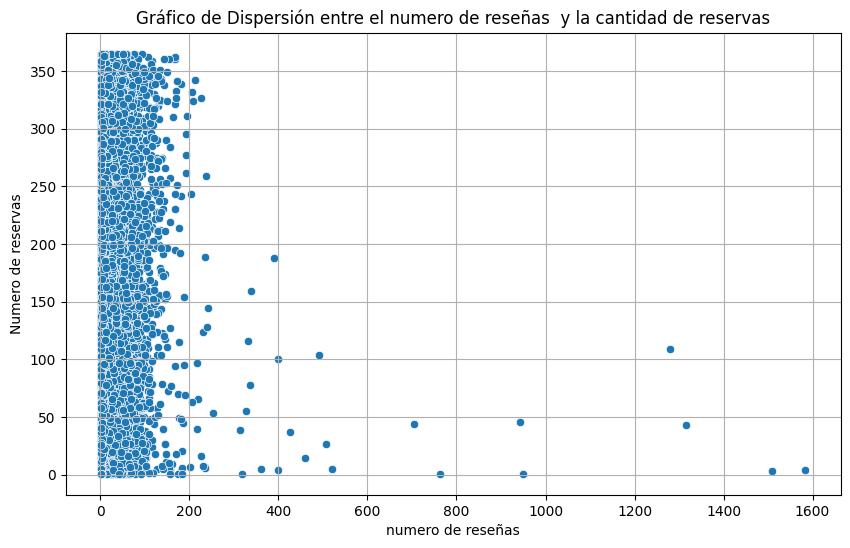

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pandas_df, x='review_count', y='booked')
plt.title('Gráfico de Dispersión entre el numero de reseñas  y la cantidad de reservas')
plt.xlabel('numero de reseñas')
plt.ylabel('Numero de reservas')
plt.grid()

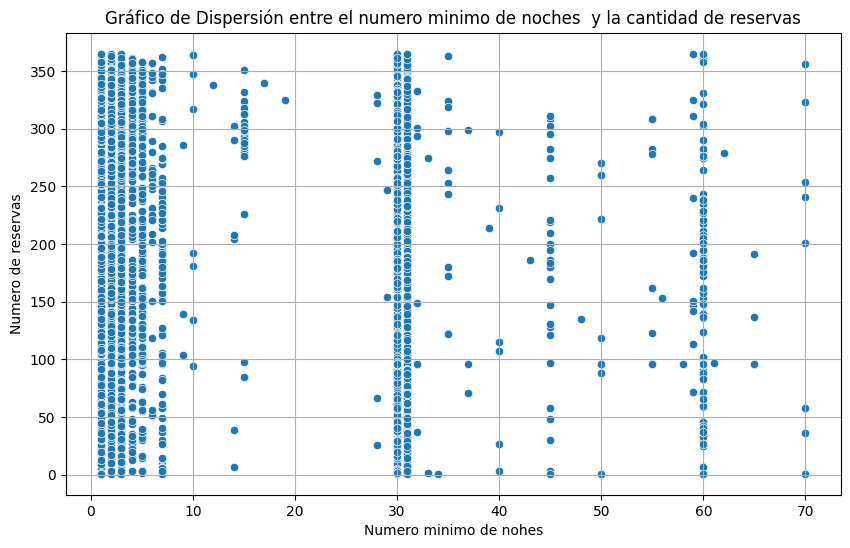

In [31]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pandas_df, x='minimum_nights', y='booked')
plt.title('Gráfico de Dispersión entre el numero minimo de noches  y la cantidad de reservas')
plt.xlabel('Numero minimo de nohes')
plt.ylabel('Numero de reservas')
plt.grid()

Se genera el histograma para validar la relacion entre el numero de alquileres y el numero de usuarios permitidos por reservas

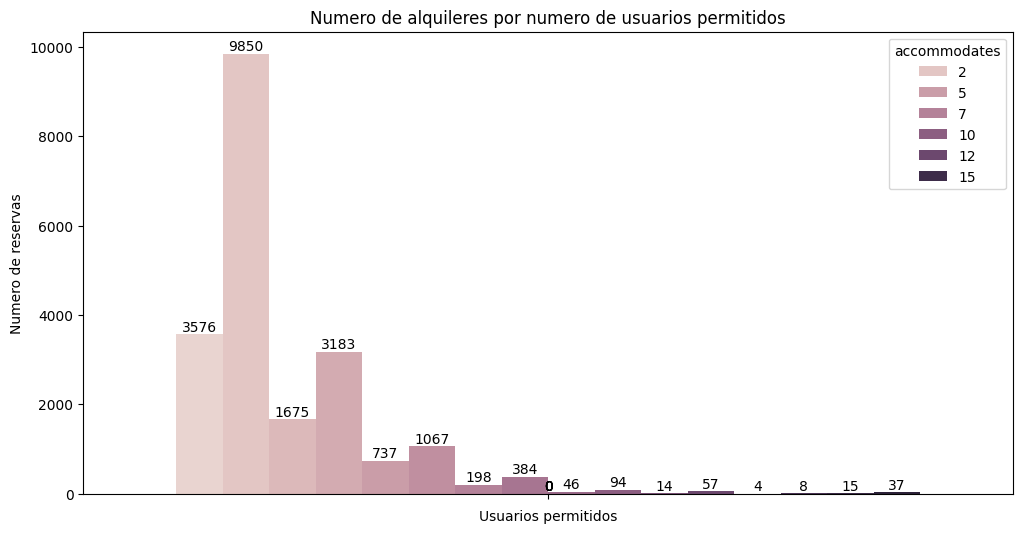

In [32]:
plt.figure(figsize=(12, 6))
mean_values = pandas_df.groupby('accommodates')['booked'].count().reset_index()
ax = sns.barplot(data=mean_values, hue='accommodates', y='booked')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')
plt.title('Numero de alquileres por numero de usuarios permitidos')
plt.xlabel('Usuarios permitidos')
plt.ylabel('Numero de reservas')
plt.show()

Se genera el histograma para validar la relacion entre el numero de camas y el numero de usuarios permitidos por reservas

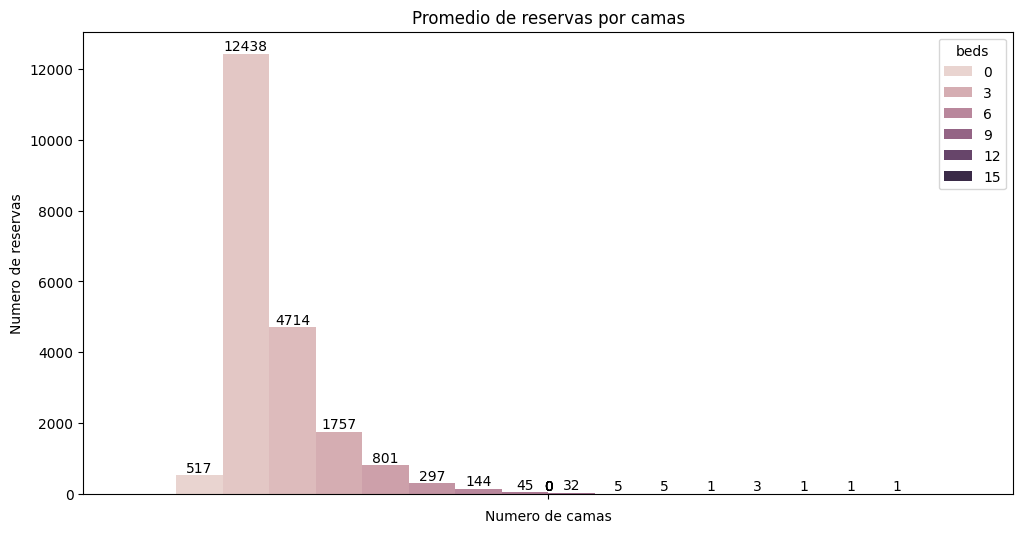

In [33]:
plt.figure(figsize=(12, 6))
mean_values = pandas_df.groupby('beds')['booked'].count().reset_index()
ax = sns.barplot(data=mean_values, hue='beds', y='booked')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')
plt.title('Promedio de reservas por camas')
plt.xlabel('Numero de camas')
plt.ylabel('Numero de reservas')
plt.show()

Se generan los histogramas de relacion entre el numero de reservas y los atrivutos mas importantes del alquiler

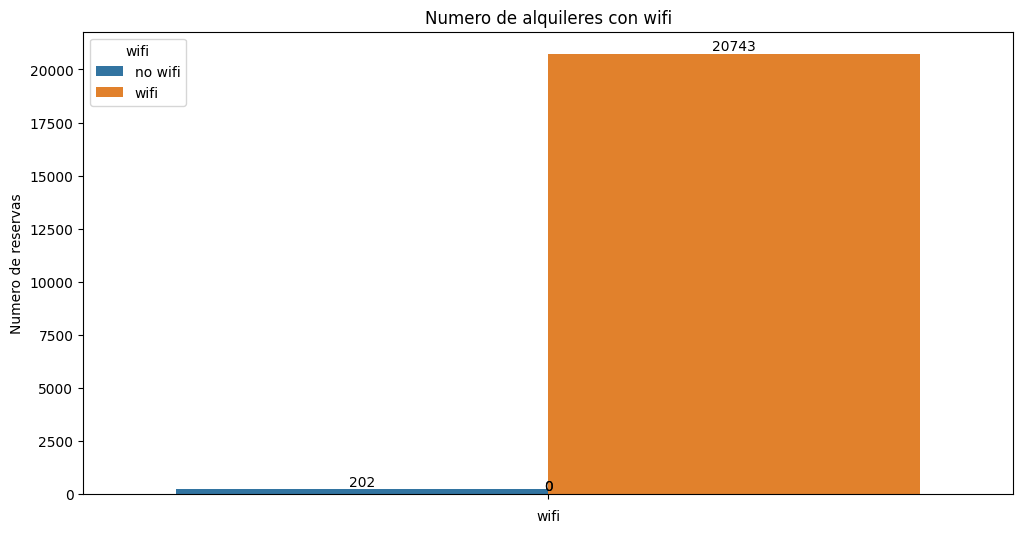

In [35]:
plt.figure(figsize=(12, 6))
mean_values = pandas_df.groupby('wifi')['booked'].count().reset_index()
ax = sns.barplot(data=mean_values, hue='wifi', y='booked')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')
plt.title('Numero de alquileres con wifi')
plt.xlabel('wifi')
plt.ylabel('Numero de reservas')
plt.show()

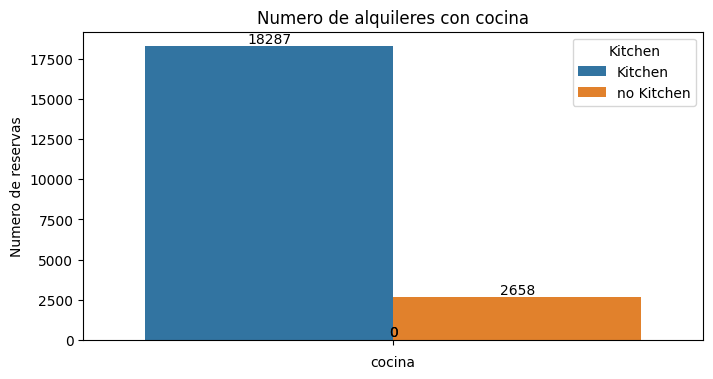

In [36]:
plt.figure(figsize=(8, 4))
mean_values = pandas_df.groupby('Kitchen')['booked'].count().reset_index()
ax = sns.barplot(data=mean_values, hue='Kitchen', y='booked')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')
plt.title('Numero de alquileres con cocina')
plt.xlabel('cocina')
plt.ylabel('Numero de reservas')
plt.show()

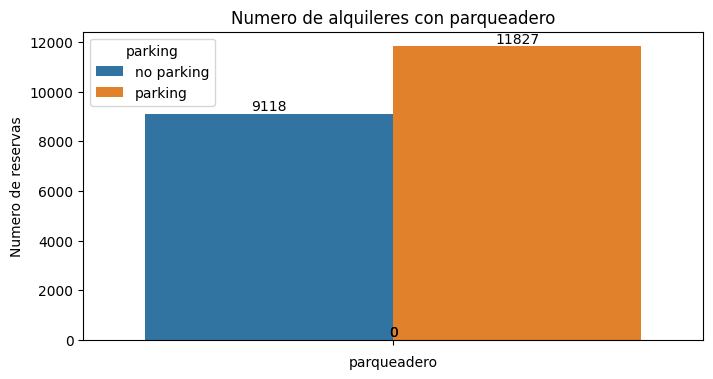

In [37]:
plt.figure(figsize=(8, 4))
mean_values = pandas_df.groupby('parking')['booked'].count().reset_index()
ax = sns.barplot(data=mean_values, hue='parking', y='booked')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')
plt.title('Numero de alquileres con parqueadero')
plt.xlabel('parqueadero')
plt.ylabel('Numero de reservas')
plt.show()

El siguiente codigo genera el top 100 de recomendaciones segun el analisis de los datos, donde se prioriza el historial de reservas por departamento

In [38]:
recomendaciones = spark.sql("""
                            select * from TablaFinal
                            where parking ='parking' and wifi='wifi' and Kitchen='Kitchen'
                            and room_type in ('Entire home/apt','Private room	')
                            and neighbourhood_group_cleansed in ('Manhattan','Brooklyn')
                            and neighbourhood_cleansed in ('Midtwon','Harlem','Upper East Side','Bedford-Stuyvesant','Williamsburg','Bushwick')
                            and price BETWEEN  100 and 300
                            and minimum_nights BETWEEN  1 and 10
                            and accommodates BETWEEN  1 and 4
                            order by booked desc
                            limit 100
                          """)


In [39]:
recomendaciones = recomendaciones.toPandas()

In [40]:
recomendaciones

,id,source,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,...,parking,price,minimum_nights,number_of_reviews,review_scores_rating,review_scores_location,license,instant_bookable,booked,review_count
0,42438973,city scrape,Harlem,Manhattan,Entire rental unit,Entire home/apt,2,1.0,1 bath,0.0,...,parking,150.0,3,62,4.87,4.82,Exempt,f,365,10.0
1,968044038797418645,city scrape,Williamsburg,Brooklyn,Entire condo,Entire home/apt,2,1.0,1 bath,0.0,...,parking,171.0,10,1,5.00,5.00,OSE-STRREG-0001794,f,364,1.0
2,1143432511272988868,city scrape,Upper East Side,Manhattan,Entire rental unit,Entire home/apt,2,1.0,1 bath,0.0,...,parking,215.0,3,1,5.00,5.00,Exempt,f,359,1.0
3,1154240334547460517,city scrape,Harlem,Manhattan,Entire rental unit,Entire home/apt,3,1.0,1 bath,1.0,...,parking,175.0,1,4,4.25,4.00,OSE-STRREG-0000476,t,356,4.0
4,793539365815167335,city scrape,Bedford-Stuyvesant,Brooklyn,Entire rental unit,Entire home/apt,2,1.0,1 bath,1.0,...,parking,165.0,2,57,4.47,4.65,OSE-STRREG-0001076,f,353,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,961527622157301522,city scrape,Bushwick,Brooklyn,Entire guesthouse,Entire home/apt,2,1.0,1 bath,2.0,...,parking,274.0,2,17,4.94,4.53,OSE-STRREG-0000585,f,129,17.0
96,968090367625068114,city scrape,Bedford-Stuyvesant,Brooklyn,Entire rental unit,Entire home/apt,3,1.0,1 bath,1.0,...,parking,211.0,2,15,5.00,4.93,OSE-STRREG-0001632,f,128,15.0
97,753687,city scrape,Bedford-Stuyvesant,Brooklyn,Entire home,Entire home/apt,2,1.0,1 bath,1.0,...,parking,150.0,3,185,4.49,4.38,OSE-STRREG-0000634,f,120,52.0
98,37082885,city scrape,Bedford-Stuyvesant,Brooklyn,Entire guest suite,Entire home/apt,2,2.0,2 baths,2.0,...,parking,227.0,2,174,4.94,4.86,OSE-STRREG-0000010,t,118,144.0


Se genera un nuevo archivo donde tendremos las recomendaciones

In [41]:
recomendaciones.to_csv('recomendaciones.csv', index=False,sep=',')